## Importing Libraries

In [124]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [89]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Load Dataset

In [90]:
df = pd.read_csv("data/raw/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## Preprocess Data

In [91]:
df.set_index("Datetime", inplace=True)
df.shape

(145366, 1)

In [92]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [93]:
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

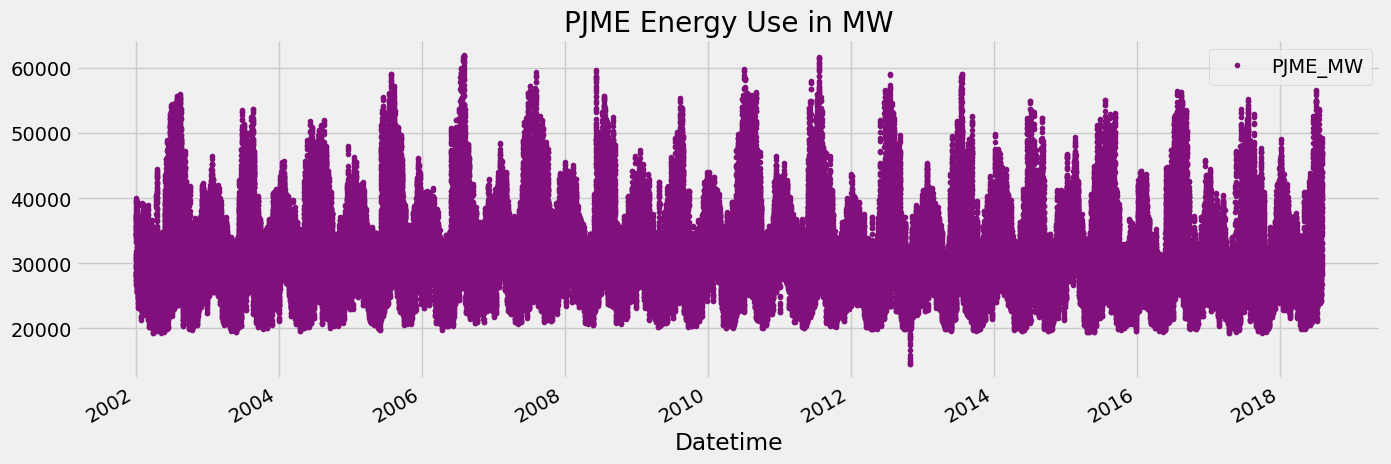

In [94]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[-1],
        title='PJME Energy Use in MW')

plt.show()

## Train Test splitting

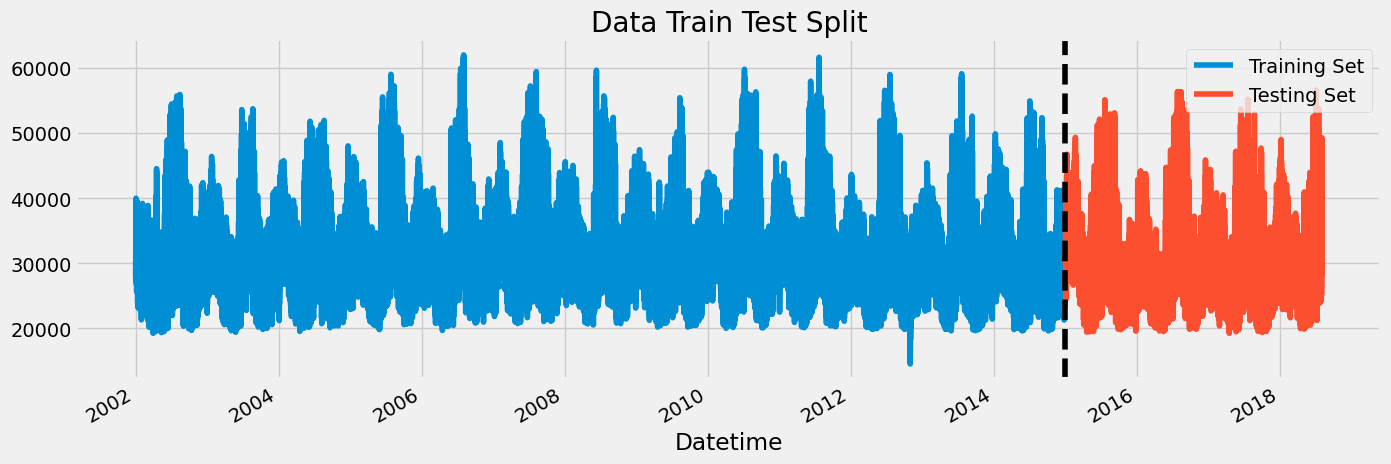

In [95]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Data Train Test Split")
test.plot(ax=ax, label="Testing Set")

ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Testing Set'])

plt.show()

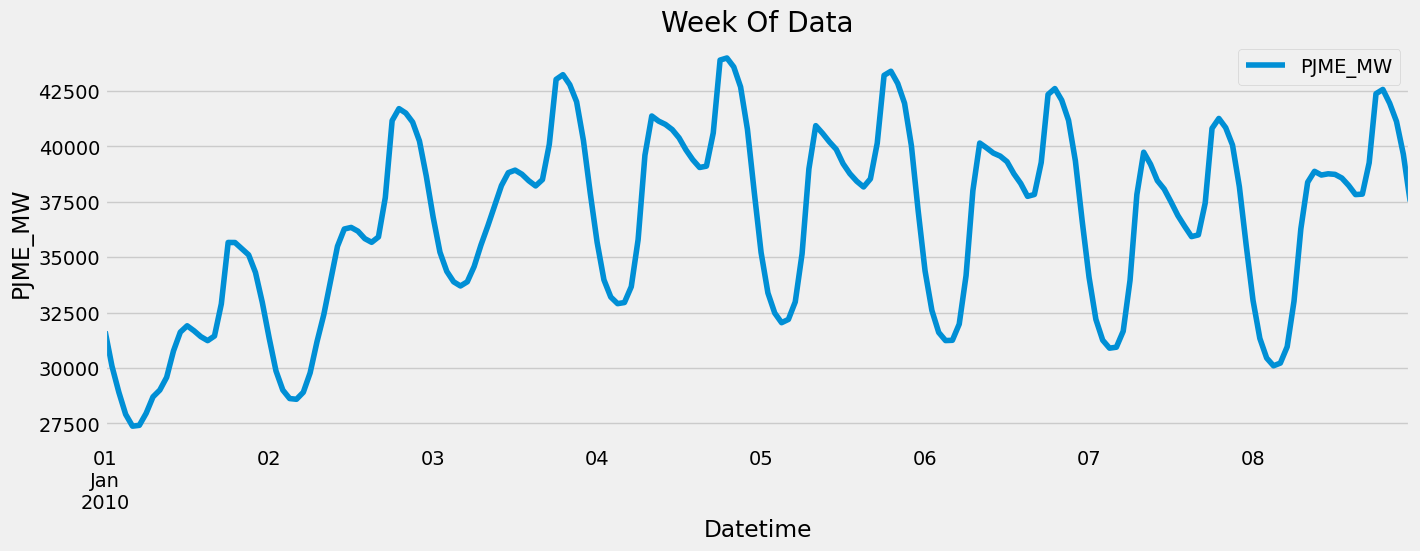

In [106]:
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]

df.loc['2010-01-01':'2010-01-08'].plot(figsize=(15, 5), title='Week Of Data')
plt.xlabel("Datetime")
plt.ylabel("PJME_MW")
plt.show()

## Feature Creation

In [110]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [111]:
df = create_features(df)

## Visualize our Feature vs Target Relationship

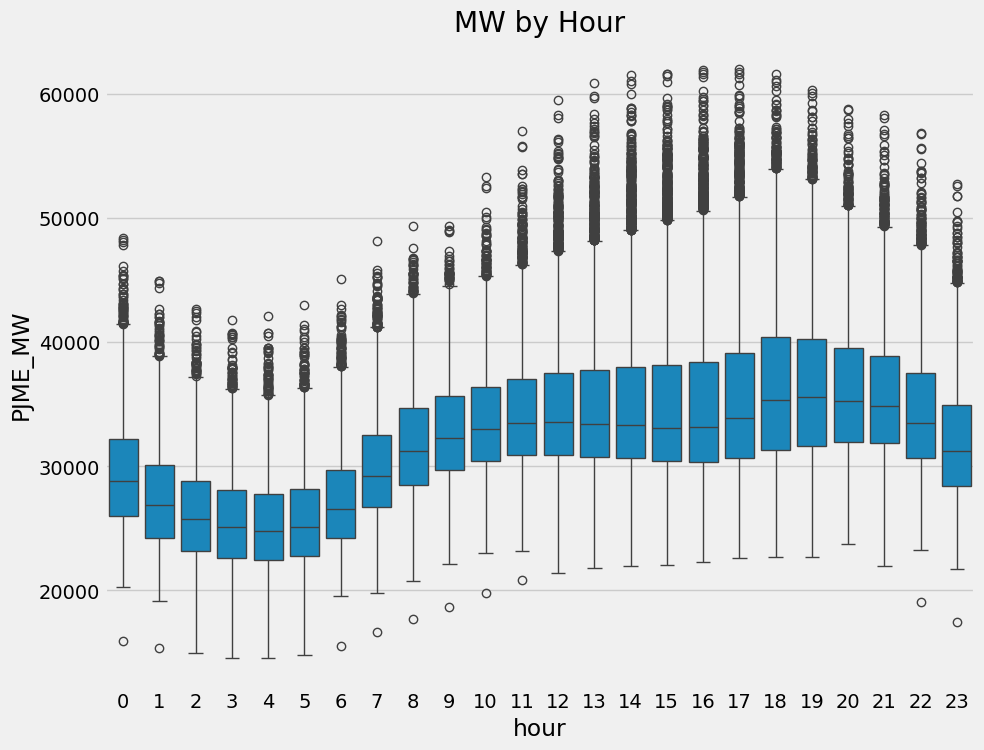

In [116]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

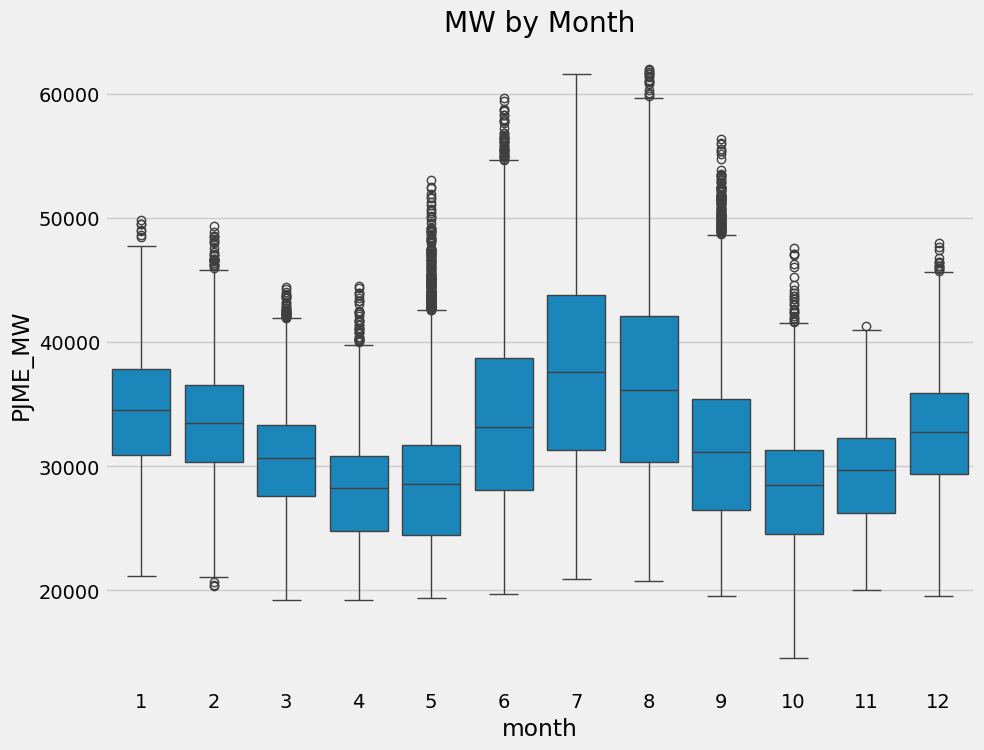

In [123]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()